# Imports

For this notebook to work, you will need to install pandas_profiling and deap libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
import random

%matplotlib inline
warnings.filterwarnings('ignore')
print(os.listdir())


['.ipynb_checkpoints', 'breast-cancer.csv', 'GeneticAlgorithm.ipynb', 'GeneticAlgorithm.py', 'KFDA.py', 'KFDA1.ipynb', 'KFDA1.py', 'paper replication.ipynb', 'pca_plot_all.png', 'pca_plot_test.png', 'pca_plot_train.png', '__pycache__']


In [2]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics.pairwise import rbf_kernel

from pandas_profiling import ProfileReport

random_state = 101

In [3]:
from GeneticAlgorithm import FeatureSelectionGA
from KFDA import KernelFisher

C:\Anacondaz\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


# Functions Needed

In [4]:
def metrics(X, y, est, split=False, cv=False, random_state=None):
    
    """
    This function prints 4 different metrics of classification based on what user wants.
    X - design matrix of features
    y - label vector
    est - trained estimator function e.g. Logistic Regression
    split - default is False
          - if True, then X is split into train and validation sets, then metrics given on validation set only
    cv - default is False
       - if True, then StratifiedKFold with 5 folds is used, and averaged metrics are given
    random_state - default is None
                 - can be given any specific seed
    """
    from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score
    if (split==True) and (cv==False):
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=0.2)
        est.fit(X_train,y_train)
        y_pred_proba = est.predict_proba(X_test)[:,1]
        y_pred_label = est.predict(X_test)
        print(f'ACCURACY is {accuracy_score(y_test, y_pred_label)}')
        print(f'RECALL is {recall_score(y_test, y_pred_label)}')
        print(f'F1 score is {f1_score(y_test, y_pred_label)}')
        print(f'ROC-AUC is {roc_auc_score(y_test, y_pred_proba)} \n')
    elif (split==False) and (cv==True):
        from sklearn.model_selection import StratifiedKFold
        skf = StratifiedKFold(5, random_state=random_state)
        rocauc, f1score, acc, rec = [],[],[],[]
        for train_ind, val_ind in skf.split(X,y):
            X_train, X_val, y_train, y_val = X[train_ind], X[val_ind], y[train_ind], y[val_ind]
            est.fit(X_train, y_train)
            y_pred_proba = est.predict_proba(X_val)[:,1]
            y_pred_label = est.predict(X_val)
            rocauc.append(roc_auc_score(y_val, y_pred_proba)/5)
            f1score.append(f1_score(y_val, y_pred_label)/5)
            acc.append(accuracy_score(y_val, y_pred_label)/5)
            rec.append(recall_score(y_val, y_pred_label)/5)
    
        print(f'ACCURACY is {sum(acc)}')
        print(f'RECALL is {sum(rec)}')
        print(f'F1 score is {sum(f1score)}')
        print(f'ROC-AUC is {sum(rocauc)} \n')
        
    else:
        est.fit(X,y)
        y_pred_proba = est.predict_proba(X)[:,1]
        y_pred_label = est.predict(X)
        print(f'ACCURACY is {accuracy_score(y, y_pred_label)}')
        print(f'RECALL is {recall_score(y, y_pred_label)}')
        print(f'F1 score is {f1_score(y, y_pred_label)}')
        print(f'ROC-AUC is {roc_auc_score(y, y_pred_proba)} \n')

# Data Loading

In [5]:
df = pd.read_csv('breast-cancer.csv')

In [6]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

# Look into Data

In [7]:
profile = ProfileReport(df)

In [8]:
profile

Number of variables,33
Number of observations,569
Total Missing (%),3.0%
Total size in memory,146.8 KiB
Average record size in memory,264.1 B
Numeric,21
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,11


# Multicollinearity

In [9]:
rejected = profile.get_rejected_variables()
rejected

['area_mean',
 'area_se',
 'area_worst',
 'concave points_mean',
 'concave points_worst',
 'perimeter_mean',
 'perimeter_se',
 'perimeter_worst',
 'radius_worst',
 'texture_worst']

In [10]:
df.drop(rejected, axis=1, inplace=True)

# Feature Selection with Genetic Algorithm

In [11]:
X = df.drop(['id', 'diagnosis', 'Unnamed: 32'], axis=1).values
y = df['diagnosis'].map({'M':0, 'B':1}).values
x_feats = list(df.drop(['id', 'diagnosis', 'Unnamed: 32'], axis=1).columns)

In [12]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=1010)
fsga = FeatureSelectionGA(model, X, y, cv_split=5, verbose=5)
pop = fsga.generate(n_pop=50, cxpb=0.8, mutxpb=0.05, ngen=300, set_toolbox=False)

EVOLVING.......
-- GENERATION 1 --
Evaluated 37 individuals
-- GENERATION 2 --
Evaluated 46 individuals
-- GENERATION 3 --
Evaluated 46 individuals
-- GENERATION 4 --
Evaluated 34 individuals
-- GENERATION 5 --
Evaluated 35 individuals
-- GENERATION 6 --
Evaluated 46 individuals
-- GENERATION 7 --
Evaluated 37 individuals
-- GENERATION 8 --
Evaluated 43 individuals
-- GENERATION 9 --
Evaluated 42 individuals
-- GENERATION 10 --
Evaluated 46 individuals
-- GENERATION 11 --
Evaluated 38 individuals
-- GENERATION 12 --
Evaluated 40 individuals
-- GENERATION 13 --
Evaluated 43 individuals
-- GENERATION 14 --
Evaluated 40 individuals
-- GENERATION 15 --
Evaluated 44 individuals
-- GENERATION 16 --
Evaluated 36 individuals
-- GENERATION 17 --
Evaluated 40 individuals
-- GENERATION 18 --
Evaluated 42 individuals
-- GENERATION 19 --
Evaluated 36 individuals
-- GENERATION 20 --
Evaluated 47 individuals
-- GENERATION 21 --
Evaluated 44 individuals
-- GENERATION 22 --
Evaluated 40 individuals
-- 

Evaluated 36 individuals
-- GENERATION 182 --
Evaluated 47 individuals
-- GENERATION 183 --
Evaluated 44 individuals
-- GENERATION 184 --
Evaluated 40 individuals
-- GENERATION 185 --
Evaluated 38 individuals
-- GENERATION 186 --
Evaluated 37 individuals
-- GENERATION 187 --
Evaluated 46 individuals
-- GENERATION 188 --
Evaluated 48 individuals
-- GENERATION 189 --
Evaluated 44 individuals
-- GENERATION 190 --
Evaluated 42 individuals
-- GENERATION 191 --
Evaluated 38 individuals
-- GENERATION 192 --
Evaluated 42 individuals
-- GENERATION 193 --
Evaluated 44 individuals
-- GENERATION 194 --
Evaluated 39 individuals
-- GENERATION 195 --
Evaluated 36 individuals
-- GENERATION 196 --
Evaluated 38 individuals
-- GENERATION 197 --
Evaluated 42 individuals
-- GENERATION 198 --
Evaluated 46 individuals
-- GENERATION 199 --
Evaluated 42 individuals
-- GENERATION 200 --
Evaluated 46 individuals
-- GENERATION 201 --
Evaluated 46 individuals
-- GENERATION 202 --
Evaluated 43 individuals
-- GENERA

In [13]:
feat_df = pd.DataFrame(list(zip(x_feats, fsga.best_ind)), columns=['name', 'keep?'])
feat_df

,name,keep?
0,radius_mean,1
1,texture_mean,1
2,smoothness_mean,0
3,compactness_mean,0
4,concavity_mean,0
5,symmetry_mean,1
6,fractal_dimension_mean,0
7,radius_se,1
8,texture_se,1
9,smoothness_se,1


In [14]:
feats_ga = feat_df[feat_df['keep?']==1]['name'].values

In [15]:
X_new = df[feats_ga]
X_new.shape

(569, 10)

# Principal Components plot

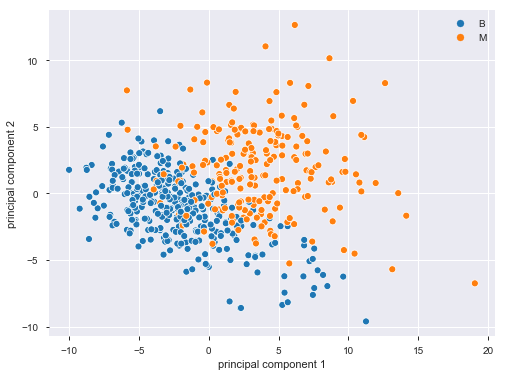

In [16]:
%matplotlib inline
pca = PCA(2)
x_pca = pca.fit_transform(X)
sns.scatterplot(x_pca[:,0][::-1], x_pca[:,1][::-1], hue=pd.Series(y[::-1]).map({0:'M', 1:'B'}))
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
fig = plt.gcf()
fig.set_size_inches(8,6)
fig.savefig('pca_plot_all.png', dpi=100)

# Splitting the data

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=319, random_state=10213)

# PCA plot of train

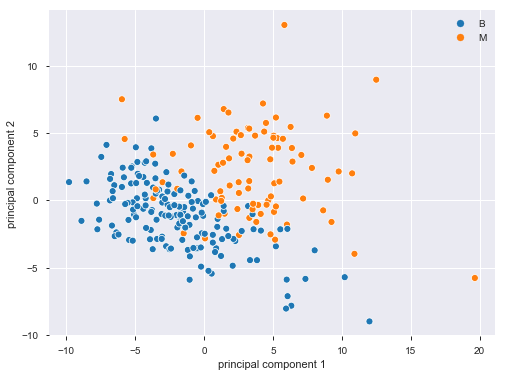

In [18]:
pca = PCA(2)
x_pca = pca.fit_transform(X_train)
sns.scatterplot(x_pca[:,0], x_pca[:,1], hue=pd.Series(y_train).map({0:'M', 1:'B'}))
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
fig = plt.gcf()
fig.set_size_inches(8,6)
fig.savefig('pca_plot_train.png', dpi=100)

# PCA plot of test

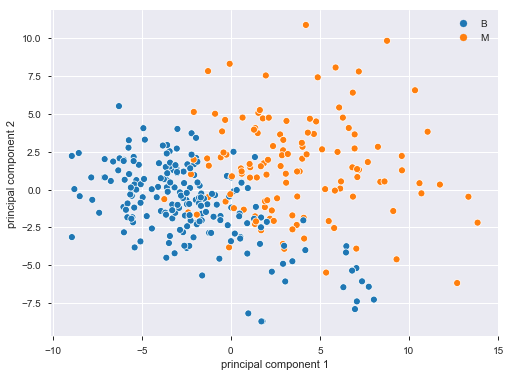

In [19]:
pca = PCA(2)
x_pca = pca.fit_transform(X_test)
sns.scatterplot(x_pca[:,0], x_pca[:,1], hue=pd.Series(y_test).map({0:'M', 1:'B'}))
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
fig = plt.gcf()
fig.set_size_inches(8,6)
fig.savefig('pca_plot_test.png', dpi=100)

# Models

In [20]:
from sklearn.model_selection import GridSearchCV

# LDA

In [21]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda_tr = lda.predict(X_train)
y_pred_lda_te = lda.predict(X_test)

print('*'*50+'   TRAIN   '+'*'*50)
print(classification_report(y_train, y_pred_lda_tr, digits=5))
print('*'*50+'   TEST    '+'*'*50)
print(classification_report(y_test, y_pred_lda_te, digits=5))

**************************************************   TRAIN   **************************************************
             precision    recall  f1-score   support

          0    0.96203   0.86364   0.91018        88
          1    0.92982   0.98148   0.95495       162

avg / total    0.94116   0.94000   0.93919       250

**************************************************   TEST    **************************************************
             precision    recall  f1-score   support

          0    0.99083   0.87097   0.92704       124
          1    0.92381   0.99487   0.95802       195

avg / total    0.94986   0.94671   0.94598       319



# SVM

LDA doesnot need tuning of parameters. Since we can tune only the solver

In [22]:
svm = SVC(random_state=101, kernel='linear')
svm.fit(X_train, y_train)
y_pred_svm_tr = svm.predict(X_train)
y_pred_svm_te = svm.predict(X_test)

print('*'*50+'   TRAIN   '+'*'*50)
print(classification_report(y_train, y_pred_svm_tr, digits=5))
print('*'*50+'   TEST    '+'*'*50)
print(classification_report(y_test, y_pred_svm_te, digits=5))

**************************************************   TRAIN   **************************************************
             precision    recall  f1-score   support

          0    0.92683   0.86364   0.89412        88
          1    0.92857   0.96296   0.94545       162

avg / total    0.92796   0.92800   0.92738       250

**************************************************   TEST    **************************************************
             precision    recall  f1-score   support

          0    0.92308   0.87097   0.89627       124
          1    0.92079   0.95385   0.93703       195

avg / total    0.92168   0.92163   0.92118       319



# Grid Search CV - SVC

In [23]:
params_svm = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000],
                      'class_weight':[None, 'balanced']},
                    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000],
                    'class_weight':[None, 'balanced']},
                    {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000],
                    'class_weight':[None, 'balanced']},
              {'kernel': ['poly'], 'C': [0.001, 0.10, 0.1, 1],
                    'class_weight':[None, 'balanced'],
                    'degree':[2,3]}
                   ]
gscv = GridSearchCV(SVC(random_state=101), params_svm, scoring='f1', cv=3, verbose=1)
gscv.fit(X_train, y_train)

Fitting 3 folds for each of 160 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    9.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=101, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.01, 0.001, 0.0001, 1e-05], 'C': [0.001, 0.1, 0.1, 10, 25, 50, 100, 1000], 'class_weight': [None, 'balanced']}, {'kernel': ['sigmoid'], 'gamma': [0.01, 0.001, 0.0001, 1e-05], 'C': [0.001, 0.1, 0.1, 10, 25, 50, 100, 1000], 'class_weight': [None, 'balanced']}...kernel': ['poly'], 'C': [0.001, 0.1, 0.1, 1], 'class_weight': [None, 'balanced'], 'degree': [2, 3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [24]:
gscv.best_params_

{'C': 100, 'class_weight': None, 'kernel': 'linear'}

In [25]:
svm = SVC(random_state=101, **gscv.best_params_)#, class_weight='balanced')
svm.fit(X_train, y_train)
y_pred_svm_tr = svm.predict(X_train)
y_pred_svm_te = svm.predict(X_test)

print('*'*50+'   TRAIN   '+'*'*50)
print(classification_report(y_train, y_pred_svm_tr, digits=5))
print('*'*50+'   TEST    '+'*'*50)
print(classification_report(y_test, y_pred_svm_te, digits=5))

**************************************************   TRAIN   **************************************************
             precision    recall  f1-score   support

          0    0.95294   0.92045   0.93642        88
          1    0.95758   0.97531   0.96636       162

avg / total    0.95594   0.95600   0.95582       250

**************************************************   TEST    **************************************************
             precision    recall  f1-score   support

          0    0.92623   0.91129   0.91870       124
          1    0.94416   0.95385   0.94898       195

avg / total    0.93719   0.93730   0.93721       319



# KFDA

In [26]:
from sklearn.neighbors import KNeighborsClassifier
kfda = KernelFisher(kernel='rbf')
kfda.fit(X_train, y_train)

knn = KNeighborsClassifier(3)
knn.fit(kfda.transform(X_train), y_train)
print(classification_report(y_train, knn.predict(kfda.transform(X_train)), digits=4))
print(classification_report(y_test, knn.predict(kfda.transform(X_test)), digits=4))

             precision    recall  f1-score   support

          0     0.9231    0.8182    0.8675        88
          1     0.9070    0.9630    0.9341       162

avg / total     0.9126    0.9120    0.9107       250

             precision    recall  f1-score   support

          0     0.9074    0.7903    0.8448       124
          1     0.8768    0.9487    0.9113       195

avg / total     0.8887    0.8871    0.8855       319



# Tuning KFDA

In [27]:
for g in np.linspace(1e-6,1,100):
    for k in ['rbf', 'linear']:
        kfda = KernelFisher(kernel=k, gamma=g)
        kfda.fit(X_train, y_train)

        knn = KNeighborsClassifier(3)
        knn.fit(kfda.transform(X_train), y_train)

        print(g,k,'----->',f1_score(y_test, knn.predict(kfda.transform(X_test))))

1e-06 rbf -----> 0.881443298969
1e-06 linear -----> 0.881443298969
0.010102 rbf -----> 0.878172588832
0.010102 linear -----> 0.881443298969
0.020203 rbf -----> 0.880597014925
0.020203 linear -----> 0.881443298969
0.030304 rbf -----> 0.888337468983
0.030304 linear -----> 0.881443298969
0.040405 rbf -----> 0.892230576441
0.040405 linear -----> 0.881443298969
0.050506 rbf -----> 0.91
0.050506 linear -----> 0.881443298969
0.060607 rbf -----> 0.891625615764
0.060607 linear -----> 0.881443298969
0.070708 rbf -----> 0.92039800995
0.070708 linear -----> 0.881443298969
0.080809 rbf -----> 0.905
0.080809 linear -----> 0.881443298969
0.09091 rbf -----> 0.916666666667
0.09091 linear -----> 0.881443298969
0.101011 rbf -----> 0.913580246914
0.101011 linear -----> 0.881443298969
0.111112 rbf -----> 0.906403940887
0.111112 linear -----> 0.881443298969
0.121213 rbf -----> 0.90099009901
0.121213 linear -----> 0.881443298969
0.131314 rbf -----> 0.875
0.131314 linear -----> 0.881443298969
0.141415 rbf ---

In [28]:
#0.070708 rbf
from sklearn.neighbors import KNeighborsClassifier

kfda = KernelFisher(kernel='rbf', gamma=0.070708)
kfda.fit(X_train, y_train)

knn = KNeighborsClassifier(3)
knn.fit(kfda.transform(X_train), y_train)
print(classification_report(y_train, knn.predict(kfda.transform(X_train)), digits=4))
print(classification_report(y_test, knn.predict(kfda.transform(X_test)), digits=4))

             precision    recall  f1-score   support

          0     0.8902    0.8295    0.8588        88
          1     0.9107    0.9444    0.9273       162

avg / total     0.9035    0.9040    0.9032       250

             precision    recall  f1-score   support

          0     0.9107    0.8226    0.8644       124
          1     0.8937    0.9487    0.9204       195

avg / total     0.9003    0.8997    0.8986       319

